<a href="https://colab.research.google.com/github/renya1993/competition_practice_/blob/main/%E5%B1%B1%E7%81%AB%E4%BA%8B%E3%81%AE%E6%B6%88%E5%A4%B1%E5%95%8F%E9%A1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

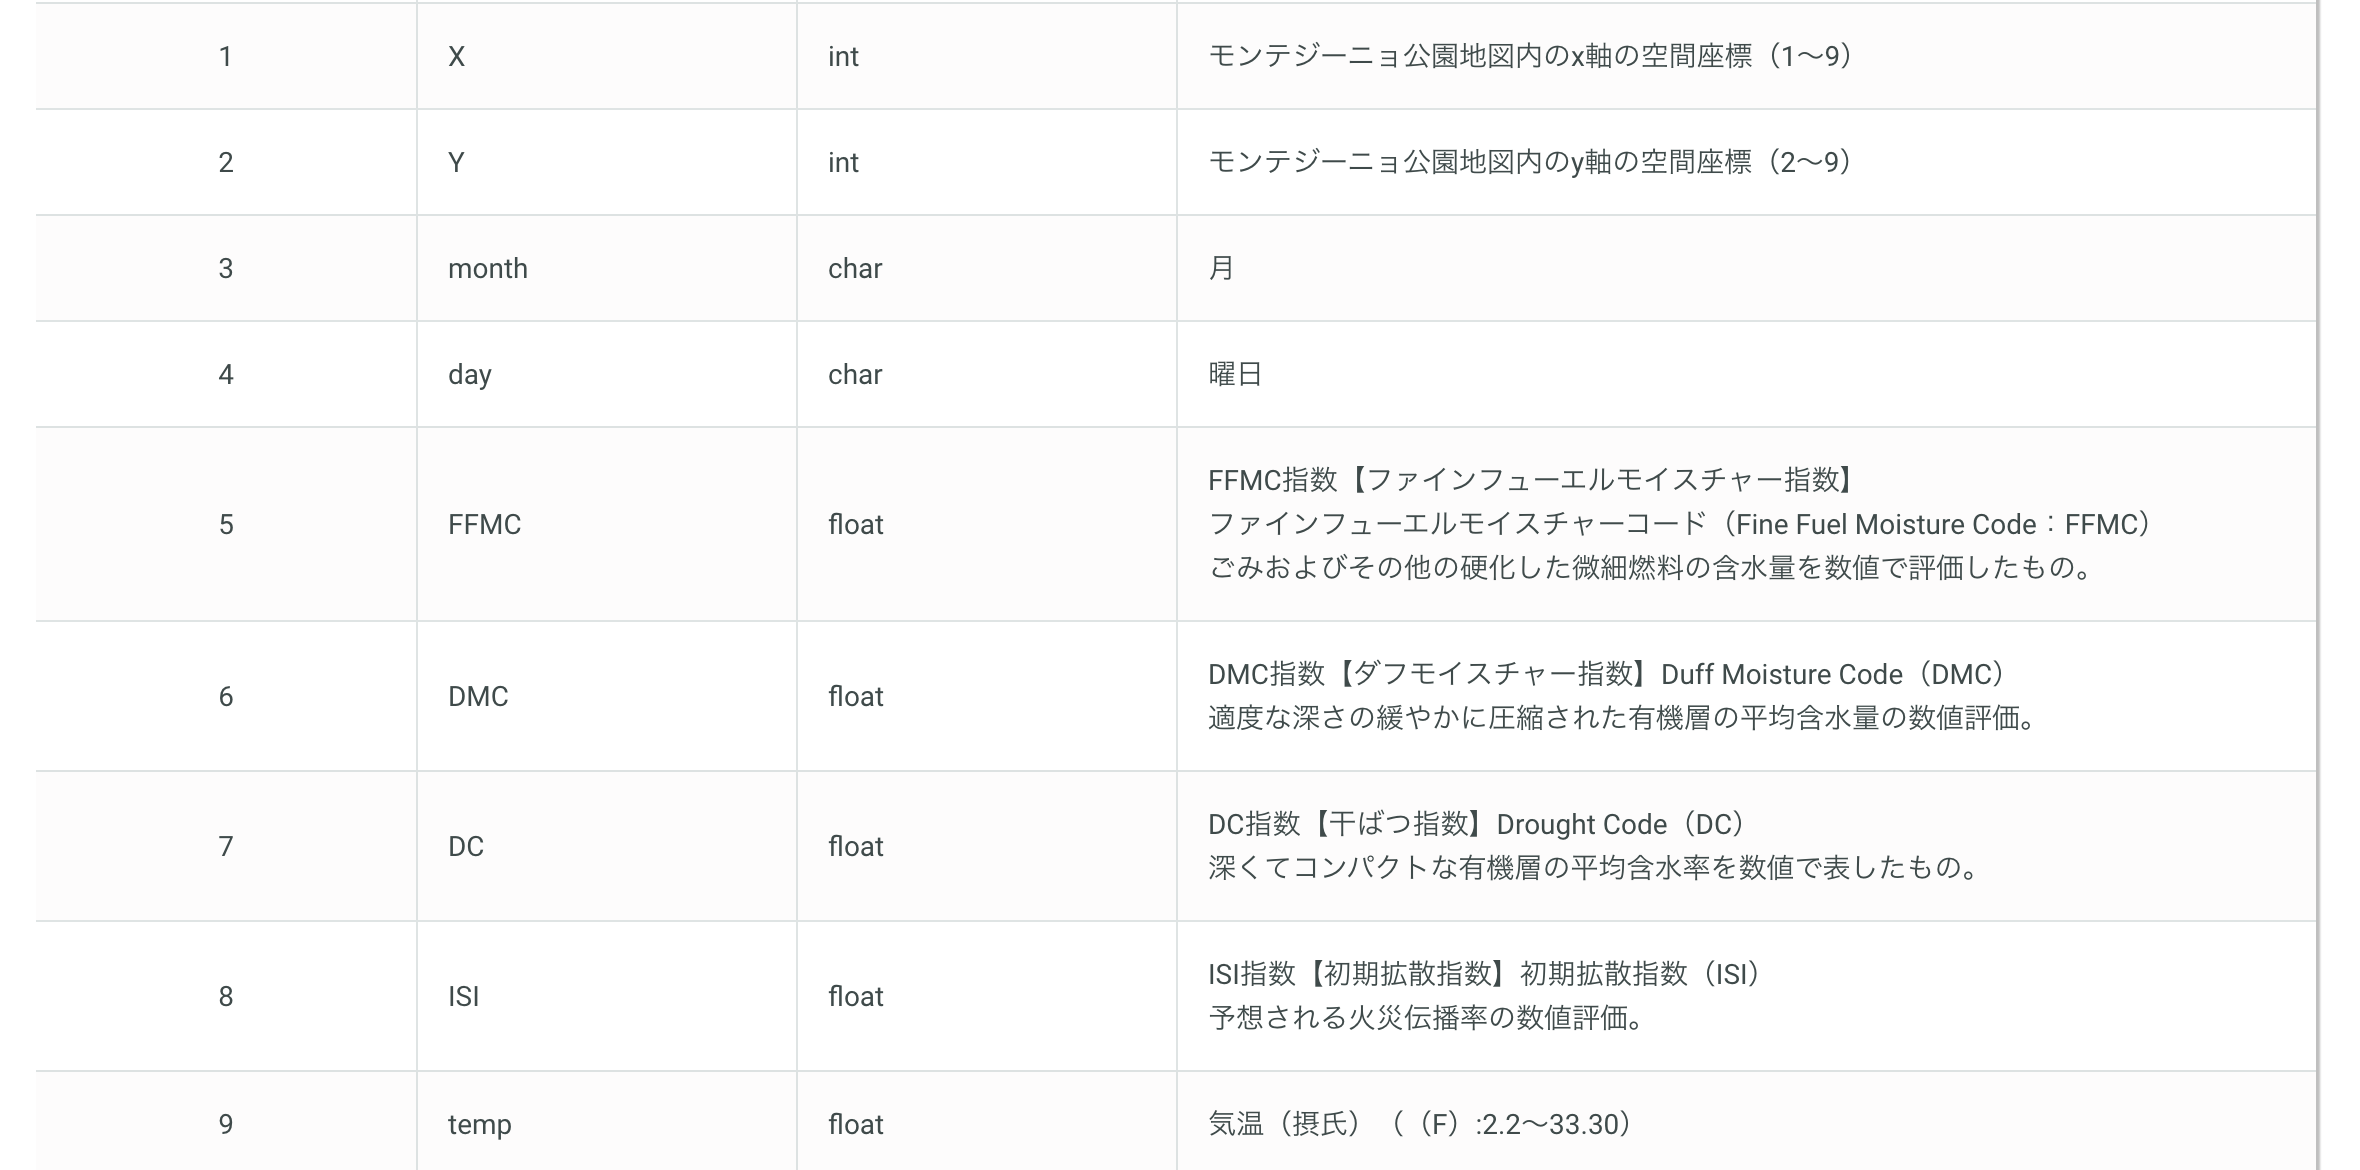

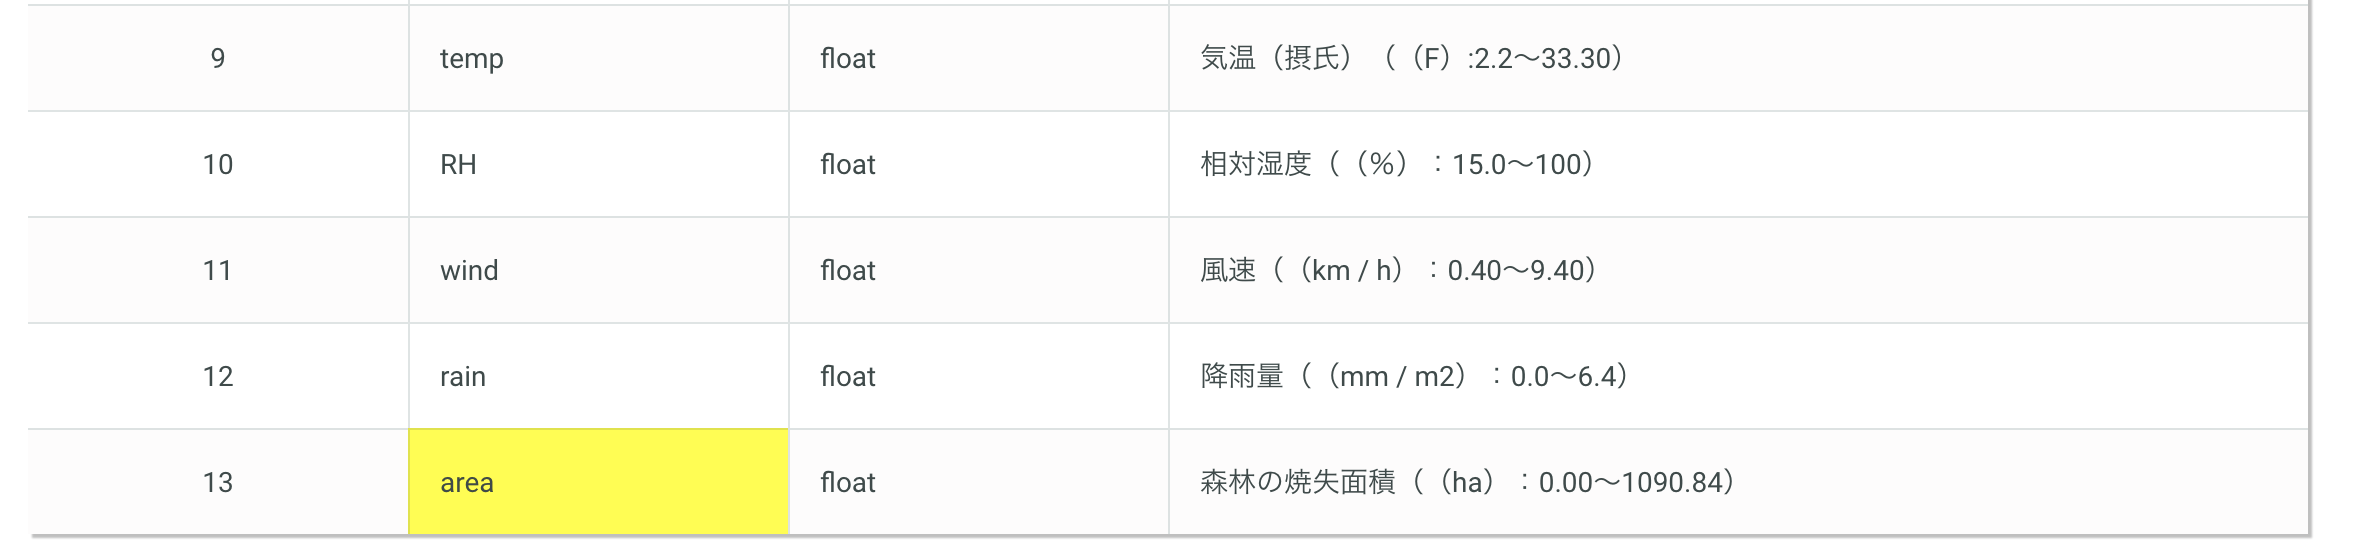

In [367]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

(259, 12)

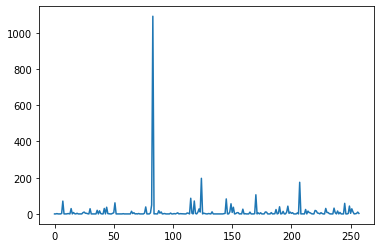

In [619]:
train = pd.read_csv("/content/drive/MyDrive/competition/山火事/train.tsv",sep='\t',index_col="id")
test = pd.read_csv("/content/drive/MyDrive/competition/山火事/test.tsv",sep='\t',index_col="id")
train["area"].max()
plt.plot(np.arange(0,train.shape[0],1),train["area"])
test.shape



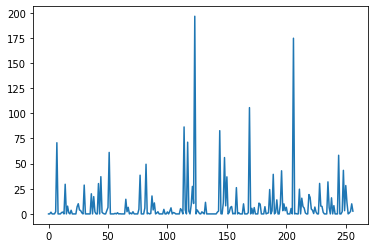

In [385]:
train=train[train["area"]!=1090.84]
plt.plot(np.arange(0,train.shape[0],1),train["area"])


In [386]:
train[train["area"]==0]["area"].shape

(122,)

In [387]:
train.shape

(257, 13)

#欠損値を探す

In [388]:
for i in train.columns.tolist():
  print(train[i].isnull().sum())

for i in test.columns.tolist():
  print(test[i].isnull().sum())
#欠損値どちらもなし

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [389]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 0 to 515
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       257 non-null    int64  
 1   Y       257 non-null    int64  
 2   month   257 non-null    object 
 3   day     257 non-null    object 
 4   FFMC    257 non-null    float64
 5   DMC     257 non-null    float64
 6   DC      257 non-null    float64
 7   ISI     257 non-null    float64
 8   temp    257 non-null    float64
 9   RH      257 non-null    int64  
 10  wind    257 non-null    float64
 11  rain    257 non-null    float64
 12  area    257 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 28.1+ KB


# 質的変数を、ダミー変数に変える

train = pd.get_dummies(train)
print("train",train.shape)
test = pd.get_dummies(test)
print("test",test.shape)
print(train.columns)
print(test.columns)


train (258, 31)
test (259, 28)
てな感じでカラム数が合わなかった。月で分けてるからっすね。
だからなし！


#object型になっていた、monthとdayをint型に変換する

In [390]:
#labelencoderを使うと、ラベルをそれぞれ何か数字に変換してくれる
"""
train側
"""

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le = le.fit(train["month"])

train["month"]=le.transform(train["month"])

le2= le.fit(train["day"])
train["day"]=le2.transform(train["day"])
train.info()

"""
test側
"""

le=LabelEncoder()
le = le.fit(test["month"])

test["month"]=le.transform(test["month"])

le2= le.fit(test["day"])
test["day"]=le2.transform(test["day"])
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 0 to 515
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       257 non-null    int64  
 1   Y       257 non-null    int64  
 2   month   257 non-null    int64  
 3   day     257 non-null    int64  
 4   FFMC    257 non-null    float64
 5   DMC     257 non-null    float64
 6   DC      257 non-null    float64
 7   ISI     257 non-null    float64
 8   temp    257 non-null    float64
 9   RH      257 non-null    int64  
 10  wind    257 non-null    float64
 11  rain    257 non-null    float64
 12  area    257 non-null    float64
dtypes: float64(8), int64(5)
memory usage: 28.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 259 entries, 1 to 516
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       259 non-null    int64  
 1   Y       259 non-null    int64  
 2   month   259 non-null    int64  

#学習データを、正解と学習に分ける

In [391]:
train_X = train.drop(columns="area")
train_Y = train["area"]

#標準化する

In [392]:
def normalization(x,y):
  return (x - y['mean']) / y['std']

#学習データに対して
train_stats = train_X.describe()
train_stats_T = train_stats.transpose()
normed_train_X = normalization(train_X,train_stats_T)

#テストデータに対して
test_stats = test.describe()
test_stats_T = test_stats.transpose()
normed_test = normalization(test,test_stats_T)

#データの分割

In [581]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(normed_train_X, train_Y, test_size = 0.01,random_state=0)

In [582]:
y_train.describe()

count    254.000000
mean       8.129370
std       22.018944
min        0.000000
25%        0.000000
50%        0.475000
75%        6.235000
max      196.480000
Name: area, dtype: float64

In [583]:
y_train

id
209     0.00
304    36.85
404     6.61
248     2.69
473     6.43
       ...  
131     6.57
389    13.99
244    71.30
91      0.00
356     0.00
Name: area, Length: 254, dtype: float64

#pytorchの実装

In [584]:
import torch
import torch.nn as nn
import torch.optim as optimizers

In [642]:
class MLP(nn.Module):
  def __init__(self,input_dim,output_dim):
    super().__init__()
    self.l1 =nn.Linear(input_dim,3)
    self.a1 =nn.ReLU()
    self.l2 =nn.Linear(3,1)
    self.a2 =nn.ReLU()
    """
    self.l2 =nn.Linear(128,64)
    self.a2 =nn.ReLU()
    self.l3 =nn.Linear(64,32)
    self.a3 =nn.ReLU()
    self.l4 =nn.Linear(32,16)
    self.a4 =nn.ReLU()
    self.l5 =nn.Linear(2,1)
    self.a5 =nn.ReLU()
    """
    self.layers = [self.l1,self.a1,self.l2,self.a2]
    """
    self.layers = [self.l1,self.a1,
                   self.l2,self.a2,
                   self.l3,self.a3,
                   self.l4,self.a4,
                   self.l5,self.a5]
    """
  def forward(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

In [643]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(x_train.shape[1],1).to(device)

criterion = nn.MSELoss()

def compute_loss(t,y):
  return criterion(y,t)

optimizer = optimizers.Adam(model.parameters(),lr=0.03)

tensor([[ 2.5870],
        [23.5367],
        [ 0.0000],
        [15.7601],
        [ 0.0000],
        [17.8291],
        [ 4.5481],
        [ 0.1793],
        [ 7.1461],
        [ 0.2946],
        [ 5.4988],
        [23.6593],
        [ 0.0000],
        [ 0.0998],
        [ 0.0000],
        [24.2176],
        [ 0.0000],
        [13.4696],
        [ 7.7364],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 8.0581],
        [ 0.0000],
        [ 4.4961],
        [ 0.0000],
        [10.9826],
        [ 0.0000],
        [ 8.1951],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 3.2214],
        [ 0.0000],
        [15.3480],
        [ 0.0000],
        [10.9226],
        [ 0.0000],
        [ 2.5270],
        [12.5836],
        [ 0.0000],
        [19.0390],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [10.3365],
        [ 0.0000],
        [ 0.0000],
        [ 6.4411],
        [ 0.0000],
        [ 0.0000],
        [ 3.

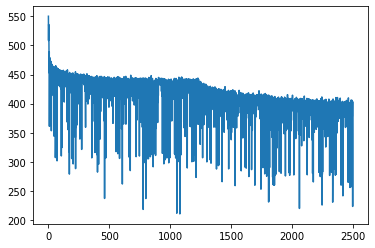

In [644]:


import matplotlib.pyplot as plt
from sklearn.utils import shuffle

def train_step(x,t):
  model.train()
  preds =model(x)
  loss = compute_loss(t,preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss

epochs = 2500
train_loss_list=[]
test_loss_list=[]

"""
データの整形
"""
x_train_row = x_train.values.reshape(-1,x_train.shape[1])
x_test_row  = x_test.values.reshape(-1,x_test.shape[1])
y_train_row = y_train.values.reshape(-1,1)
y_test_row  = y_test.values.reshape(-1,1)

batch_size = 30
n_batches = x_train.shape[0] // batch_size


for epoch in range(epochs):
  train_loss = 0
  x_train_row,y_train_row = shuffle(x_train_row,y_train_row)
  #x_test_row,y_test_row = shuffle(x_test_row,y_test_row)
  x_ = torch.Tensor(x_train_row).to(device)
  t_ = torch.Tensor(y_train_row).to(device)

  for n_batch in range(n_batches):
    start = n_batch *batch_size
    end = start+batch_size
    loss_train = train_step(x_[start:end],t_[start:end]).data.cpu().numpy()
    train_loss+=loss_train/n_batches
  #x_t = torch.Tensor(x_test_row).to(device)
  #t_t = torch.Tensor(y_test_row).to(device)
  #loss_train = train_step(x_,t_).data.cpu().numpy()
  #loss_test = compute_loss(x_t,t_t).data.cpu().numpy()

  train_loss_list.append(train_loss)
  #test_loss_list.append(loss_test)

  now_epoch = epoch

#print(train_loss_list)
plt.plot(np.arange(0,now_epoch+1,1),train_loss_list)
#plt.plot(np.arange(0,now_epoch+1,1),test_loss_list)
#print(now_epoch)
print(model(x_))

In [645]:
def test_step(x,t):
  x = torch.Tensor(x).to(device)
  t = torch.Tensor(t).to(device)
  model.eval()
  preds = model(x)
  loss = compute_loss(t,preds)
  return loss,preds

loss,preds = test_step(x_test_row,y_test_row)
test_loss = loss.item()
preds = preds.data.cpu().numpy()

from sklearn.metrics import mean_squared_error as MSE
mse_test = MSE(y_test,preds)
rmse_test = np.sqrt(mse_test)

print(rmse_test)

9.649023456070042


In [646]:
#test_row = normed_test.values.reshape(-1,test.shape[1])
test_tensor = torch.Tensor(test_row).to(device)

preds_real = model(test_tensor).data.cpu().numpy()
preds_real.shape

(259, 1)

In [647]:
test["area"]=pd.DataFrame(preds_real).values

test["area"]

id
1      17.962643
2       2.958111
4       0.000000
5      23.333553
6       4.992706
7      12.160572
8       0.000000
10      0.000000
12      0.000000
14      0.000000
15      9.318478
17      0.000000
18      0.000000
20      0.000000
21      0.000000
22      0.000000
26      0.000000
30      0.000000
34      0.000000
37      6.882328
45     11.769588
46      8.323959
49      0.000000
51      5.817657
52      0.000000
54      6.089840
55      1.667923
56      0.000000
59      0.000000
60      0.000000
63      0.000000
64      7.985577
65     12.771893
66      0.000000
68      0.000000
71      0.000000
74      0.000000
75      0.000000
76      0.000000
78      0.000000
81      5.274235
85      0.000000
89     20.771622
90      0.000000
92      0.000000
93      0.000000
96      0.000000
97      0.000000
100    12.574306
101     0.000000
102     0.000000
103     0.000000
106     0.000000
107     0.000000
108     0.000000
112     0.000000
113     0.000000
114     0.000000
116     0.0